In [28]:
import pickle

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np

In [2]:
with open('../data/interim/02_cleaned.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [3]:
with open('../data/interim/05_nmf_topics.pkl', 'rb') as picklefile:
    df_topics = pickle.load(picklefile)

In [4]:
df_topics = df_topics[['neighborhood', 'city', 'topic']]

In [5]:
df_listings = df_listings.merge(df_topics, how='left', on=['neighborhood', 'city'])

In [6]:
df_listings = df_listings.dropna().reset_index(drop=True)

#### Create dummy variables

In [7]:
cat_columns = ['host_is_superhost', 'host_response_time', 'cancellation_policy', 'room_type']

In [8]:
df_dummies = df_listings[['neighborhood', 'city', 'reviews_per_month', 'topic', 'bathrooms', 'property_type']]

In [9]:
df_dummies.loc[df_dummies['bathrooms'] <= 1, 'bathrooms'] = 0
df_dummies.loc[df_dummies['bathrooms'] > 1, 'bathrooms'] = 1
df_dummies.rename(columns={'bathrooms': 'multiple_bathrooms'}, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [10]:
conventional = ['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse']
professional = ['Bed & Breakfast', 'Hostel', 'Boutique Hotel']

In [11]:
df_dummies.loc[:, 'property_cat'] = df_dummies['property_type'].apply(lambda x: 'conventional' if x in conventional else ('professional' if x in professional else 'quirky'))
df_temp = pd.get_dummies(df_dummies['property_cat'], drop_first=True)
df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)
df_dummies.drop(['property_type', 'property_cat'], axis=1, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [12]:
df_dummies.head()

,neighborhood,city,reviews_per_month,topic,multiple_bathrooms,professional,quirky
0,Brentwood,austin,0.17,6_campus,0.0,0.0,0.0
1,Rosedale,austin,0.31,6_campus,1.0,1.0,0.0
2,Rosedale,austin,0.46,6_campus,0.0,0.0,0.0
3,Rosedale,austin,4.29,6_campus,0.0,0.0,0.0
4,Rosedale,austin,3.30,6_campus,0.0,0.0,0.0


In [13]:
for column in cat_columns:
    df_temp = pd.get_dummies(df_listings[column], drop_first=False, prefix=column)
    df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)

In [14]:
df_dummies.columns

Index([u'neighborhood', u'city', u'reviews_per_month', u'topic',
       u'multiple_bathrooms', u'professional', u'quirky',
       u'host_is_superhost_f', u'host_is_superhost_t',
       u'host_response_time_a few days or more',
       u'host_response_time_no response', u'host_response_time_within a day',
       u'host_response_time_within a few hours',
       u'host_response_time_within an hour', u'cancellation_policy_flexible',
       u'cancellation_policy_moderate', u'cancellation_policy_no_refunds',
       u'cancellation_policy_strict', u'cancellation_policy_super_strict_30',
       u'cancellation_policy_super_strict_60', u'room_type_Entire home/apt',
       u'room_type_Private room', u'room_type_Shared room'],
      dtype='object')

In [15]:
df_dummies.drop(['host_is_superhost_f', 'host_response_time_within an hour', 'cancellation_policy_flexible', 'room_type_Entire home/apt'], axis=1, inplace=True)

#### Standardize numerical features

In [16]:
numerical_columns = ['price_person', 'review_scores_rating']

In [17]:
scale = StandardScaler()
df_num = pd.DataFrame(scale.fit_transform(df_listings[numerical_columns]))
df_num.columns = numerical_columns

#### Merge dataframes

In [18]:
df_model = df_dummies.merge(df_num, left_index=True, right_index=True)

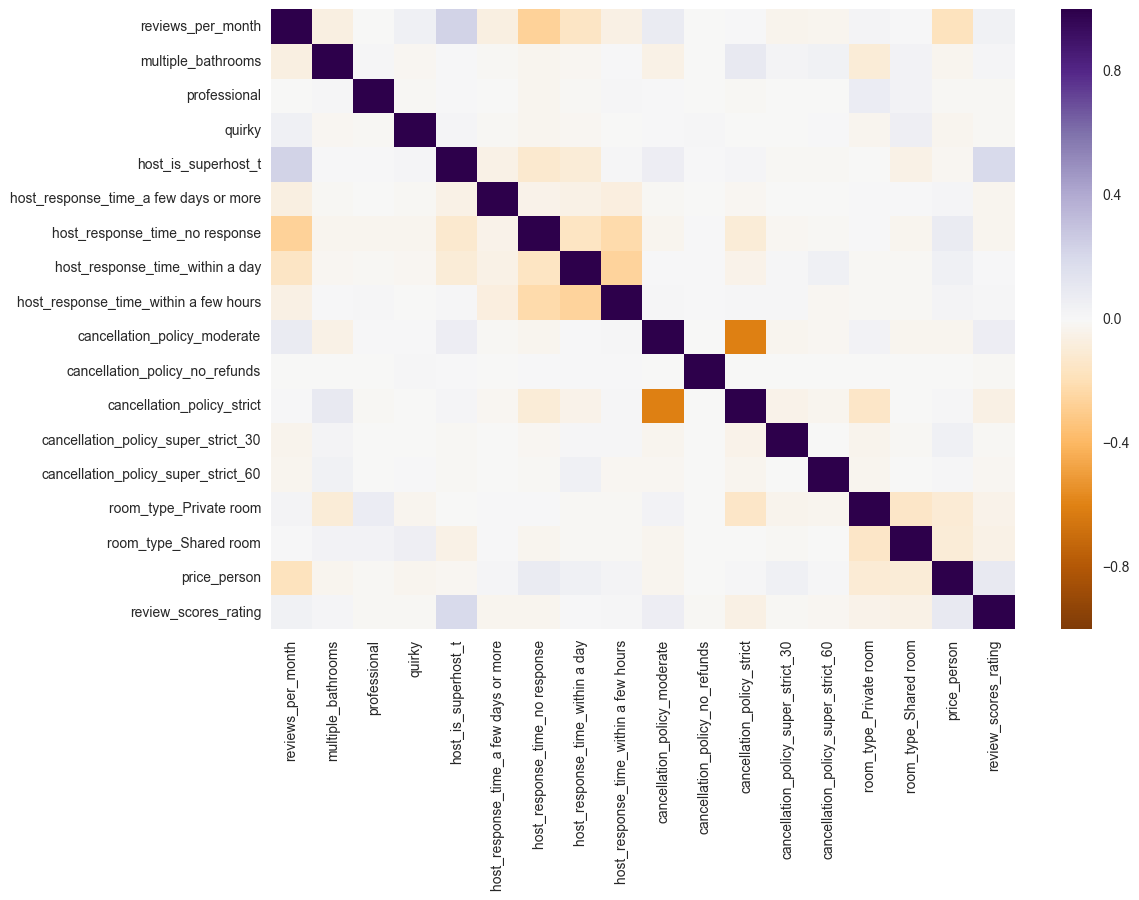

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_model.corr(), ax=ax, cmap="PuOr");

In [20]:
X = df_model.drop(['neighborhood', 'city', 'topic'], axis=1)
y = X.pop('reviews_per_month')

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [74]:
lr = LinearRegression()

In [75]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.21431486743883232

In [76]:
lr.score(X_test, y_test)

0.21275227036328803

In [77]:
y_pred = lr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

1.5568447131805936

In [78]:
baseline_y = lr.coef_.tolist()

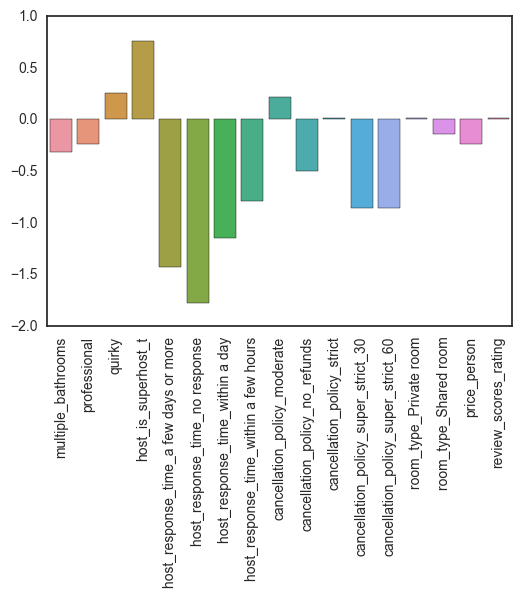

In [30]:
features = X.columns.tolist()
coefficients = lr.coef_.tolist()
fig = sns.barplot(features, coefficients)
plt.xticks(rotation=90);

### Hyperlocal models

In [31]:
clusters = df_model['topic'].unique().tolist()
clusters.sort()

In [32]:
clusters

['10_attractions',
 '11_golf',
 '12_outdoors',
 '13_streetcars',
 '14_water',
 '15_breweries',
 '16_bikes',
 '1_taco',
 '2_subway',
 '3_car',
 '4_museum',
 '5_farmer',
 '6_campus',
 '7_diverse',
 '8_art',
 '9_nightlife']

In [79]:
#keep features to plot coefficients across clusters
from collections import defaultdict
coef_values = dict.fromkeys(features)
for key in coef_values.keys():
    coef_values[key] = []

cluster_values = dict.fromkeys(clusters)
for key in cluster_values.keys():
    cluster_values[key] = []

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [80]:
def plot_hyperlocals(cluster):
    X_temp = df_model[df_model['topic'] == cluster].drop(['neighborhood', 'city', 'topic'], axis=1)
    y_temp = X_temp.pop('reviews_per_month')
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=16)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', RMSE: ' + str(score)
    
    #score = lr.score(X_test, y_test)
    #title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', r^2: ' + str(score)
    
    features = X_temp.columns.tolist()
    coefficients = lr.coef_.tolist()
    
    cluster_values[cluster] = coefficients
    
    for feature, coefficient in zip(features, coefficients):
        coef_values[feature].append(coefficient)

    fig, ax = plt.subplots()
    fig = sns.barplot(features, coefficients)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(title)
    plt.xticks(rotation=90);

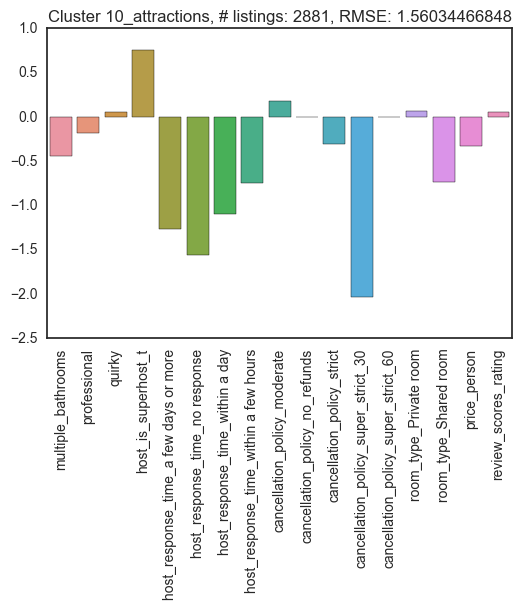

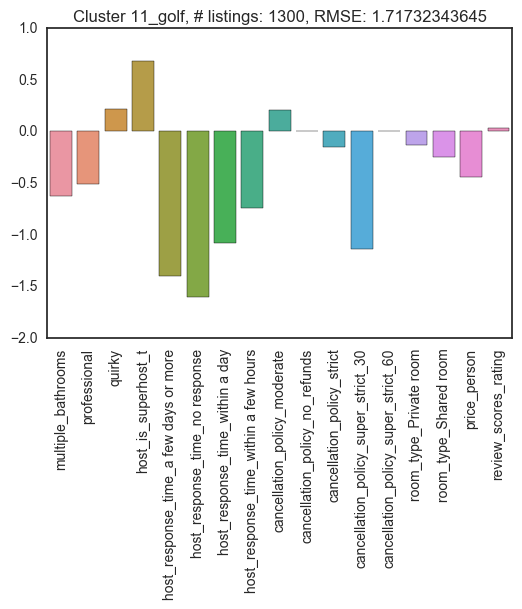

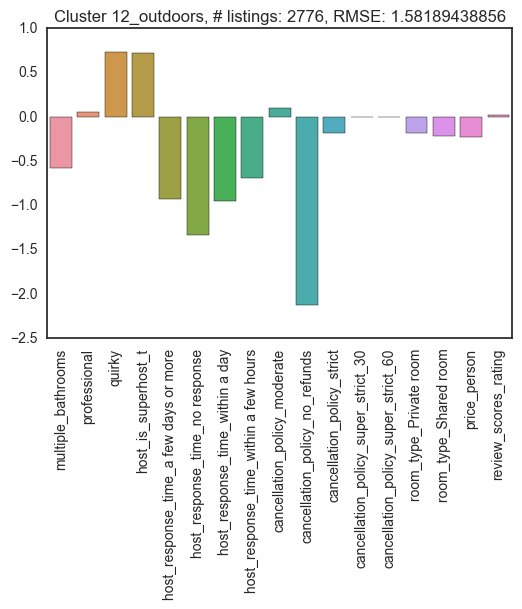

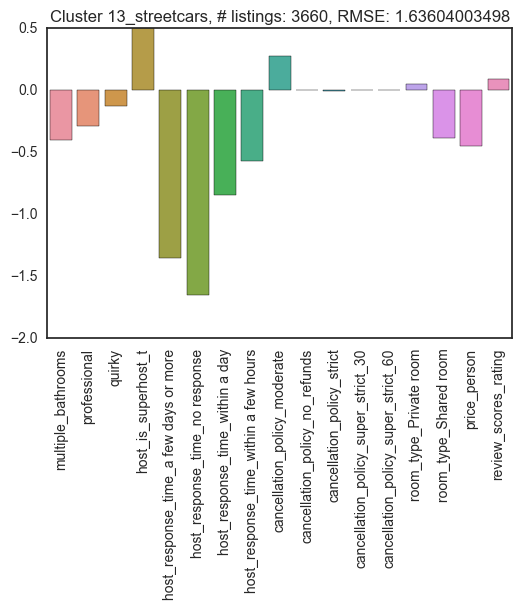

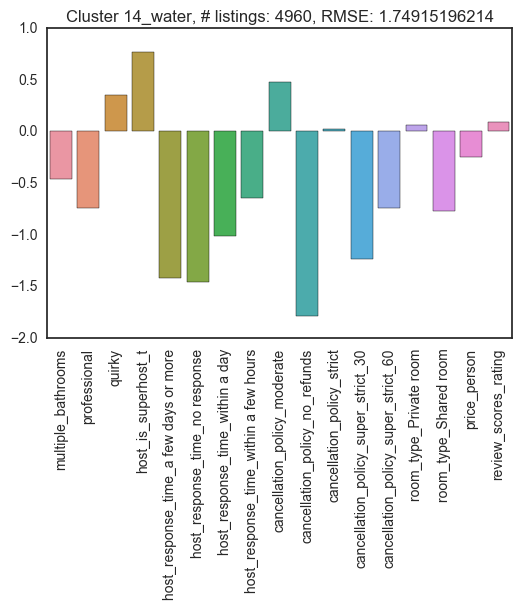

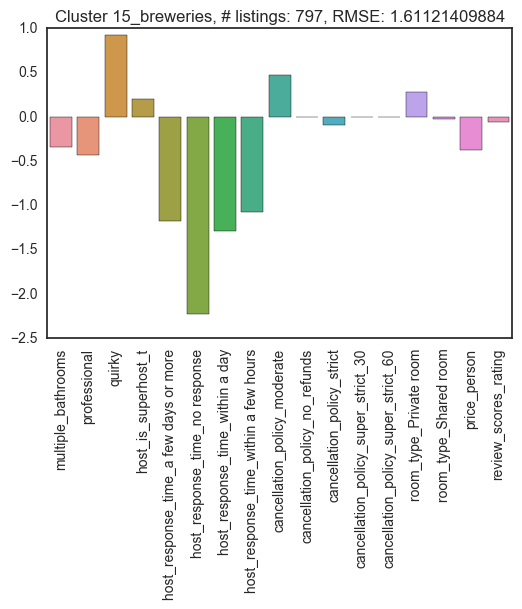

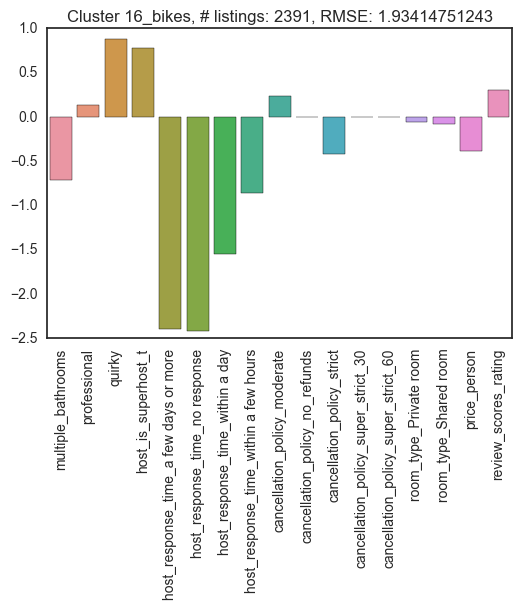

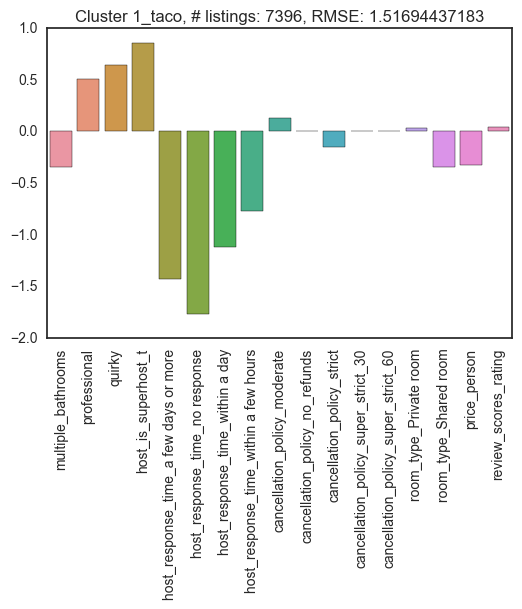

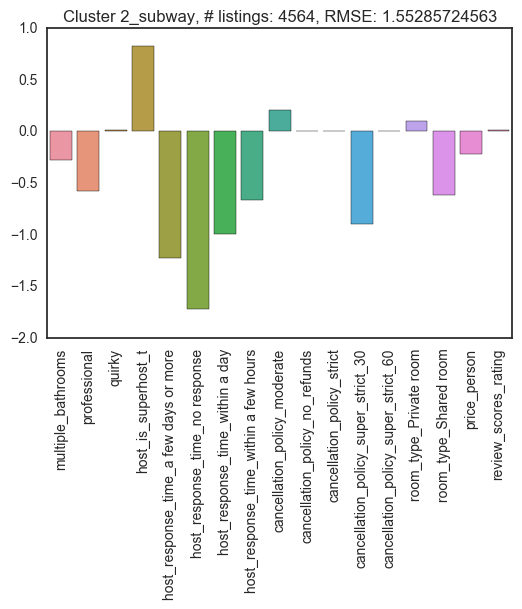

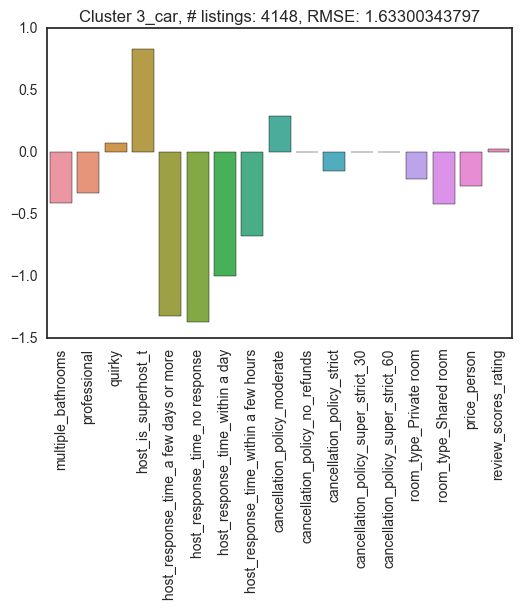

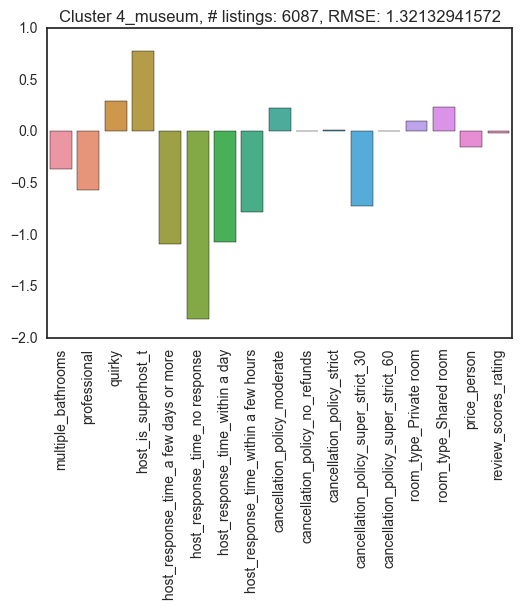

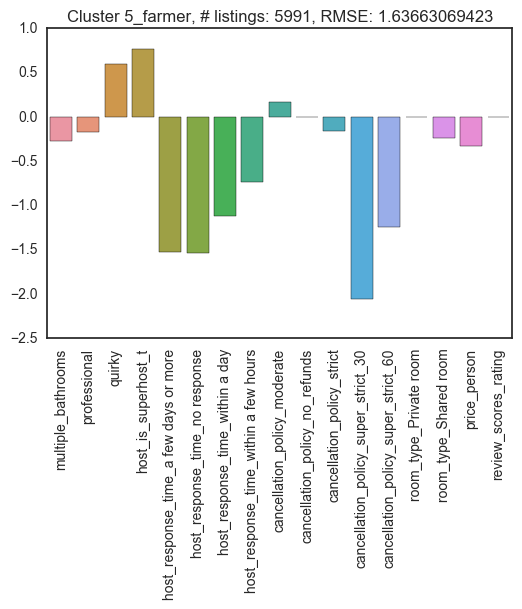

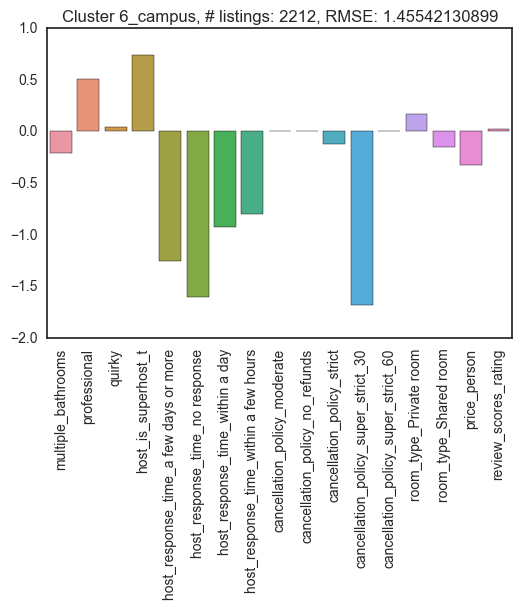

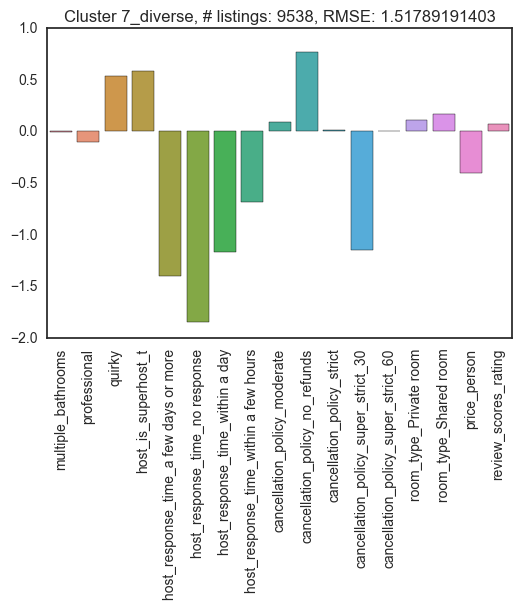

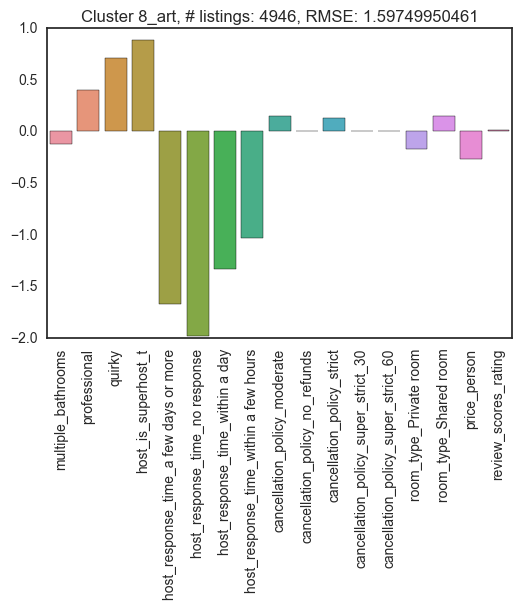

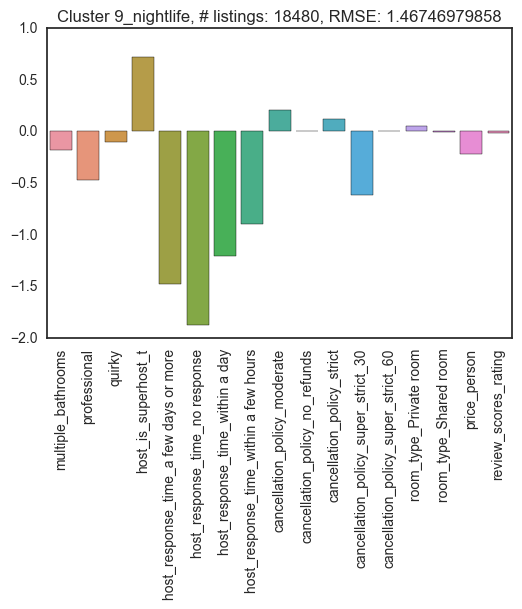

In [81]:
for cluster in clusters:
    plot_hyperlocals(cluster)

In [136]:
def plot_overlapping_bars(baseline_y, comparison_y):
    fig, ax = plt.subplots()
    num_bars = range(len(baseline_y))
    baseline_bar_width = 1.0
    comparison_bar_width = 0.5
    ax.set_title(cluster)
    ax.set_xlim(-3, 1.5)
    #ax.set_xticklabels(X.columns.tolist())
    plt.xticks(rotation=90)
    ax.barh(num_bars, baseline_y, baseline_bar_width, color='#cccccc', align='center')
    ax.barh(num_bars, comparison_y, comparison_bar_width, color = '#238985', align='center');

In [137]:
X.columns.tolist()

['multiple_bathrooms',
 'professional',
 'quirky',
 'host_is_superhost_t',
 'host_response_time_a few days or more',
 'host_response_time_no response',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'cancellation_policy_moderate',
 'cancellation_policy_no_refunds',
 'cancellation_policy_strict',
 'cancellation_policy_super_strict_30',
 'cancellation_policy_super_strict_60',
 'room_type_Private room',
 'room_type_Shared room',
 'price_person',
 'review_scores_rating']

In [143]:
!ls ../reports/viz

bubble_plots.html             neighborhood_clusters.html
d3                            nmf_topic_word_stemplots.html
data                          total_listings.html
force_plot.html               total_listings0.html
lda_topic_word_stemplots.html


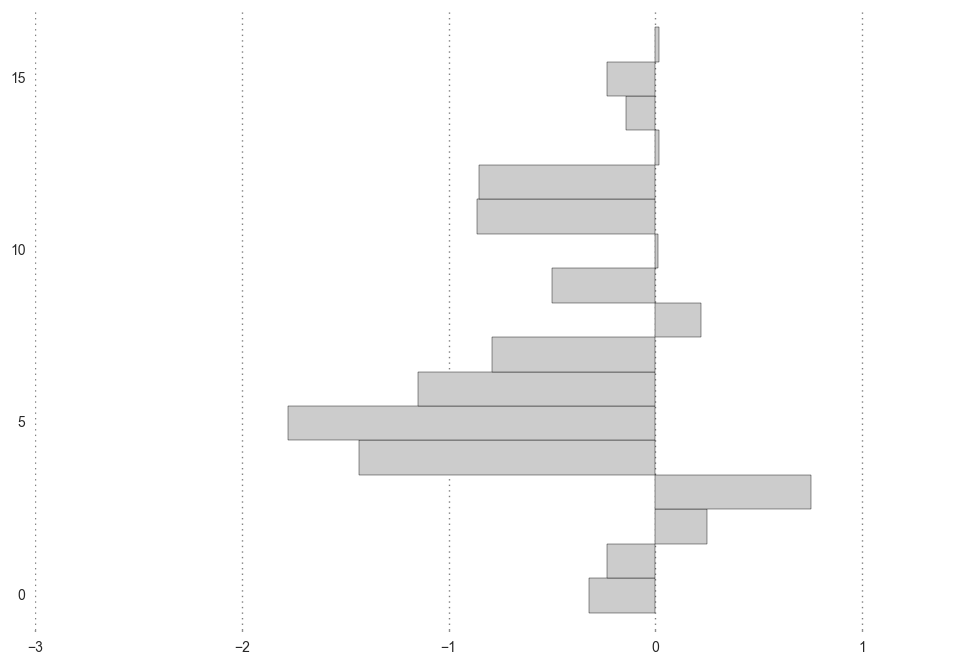

In [187]:
sns.set_style("whitegrid", {"grid.linestyle": ":",
                            "grid.color": "0.5",
                            "xtick.major.size": "1.0"})
fig, ax = plt.subplots(figsize=(12, 8))
num_bars = range(len(baseline_y))
baseline_bar_width = 1.0
comparison_bar_width = 0.45
ax.set_xlim(-3, 1.5)
ax.set_xticks(np.arange(-3, 2, 1) )
ax.set_ylim(-1, 17)
ax.yaxis.grid(False)
ax.barh(num_bars, baseline_y, baseline_bar_width, color='#cccccc', align='center')
#ax.barh(num_bars, cluster_values['16_bikes'], comparison_bar_width, color = '#238985', align='center')
sns.despine(fig=fig, ax=ax, left=True, bottom=True);
plt.savefig('../reports/viz/baseline.png')

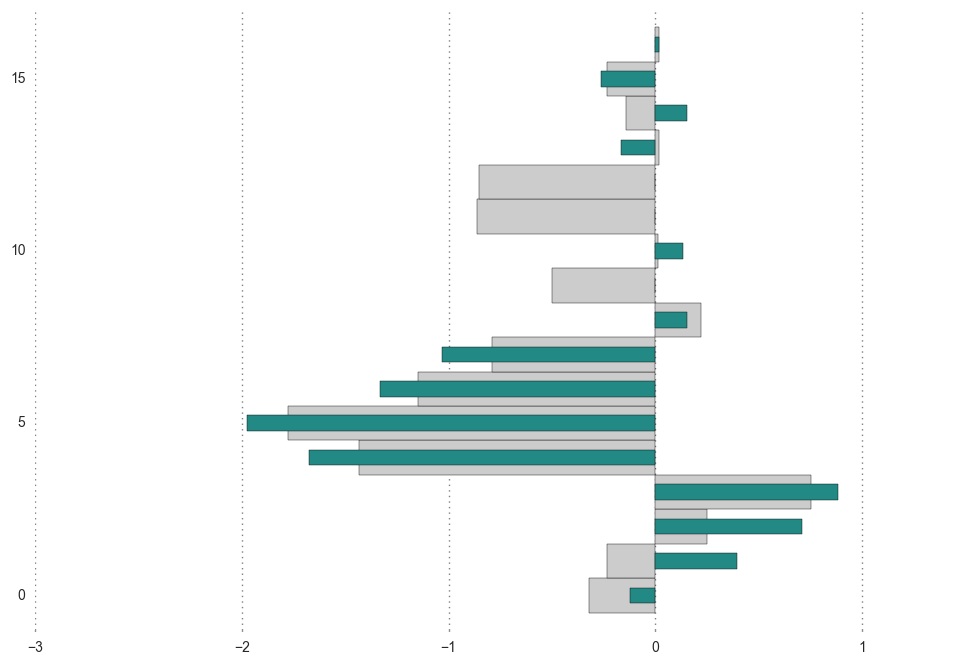

In [188]:
sns.set_style("whitegrid", {"grid.linestyle": ":",
                            "grid.color": "0.5",
                            "xtick.major.size": "1.0"})
fig, ax = plt.subplots(figsize=(12, 8))
num_bars = range(len(baseline_y))
baseline_bar_width = 1.0
comparison_bar_width = 0.45
ax.set_xlim(-3, 1.5)
ax.set_xticks(np.arange(-3, 2, 1) )
ax.set_ylim(-1, 17)
ax.yaxis.grid(False)
ax.barh(num_bars, baseline_y, baseline_bar_width, color='#cccccc', align='center')
ax.barh(num_bars, cluster_values['8_art'], comparison_bar_width, color = '#238985', align='center')
sns.despine(fig=fig, ax=ax, left=True, bottom=True);
plt.savefig('../reports/viz/art.png')

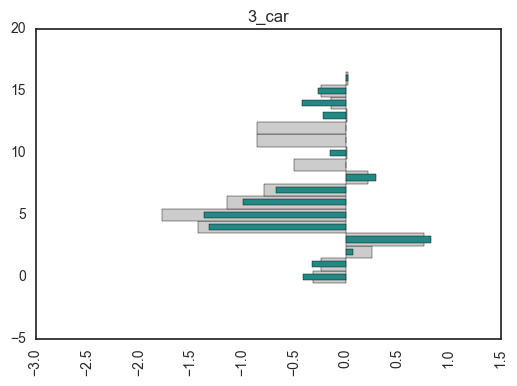

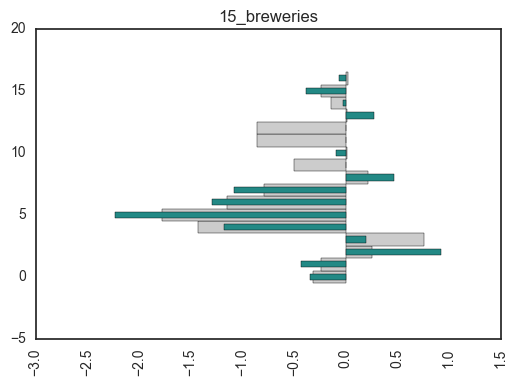

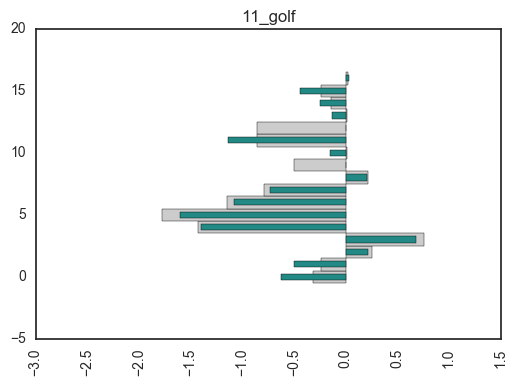

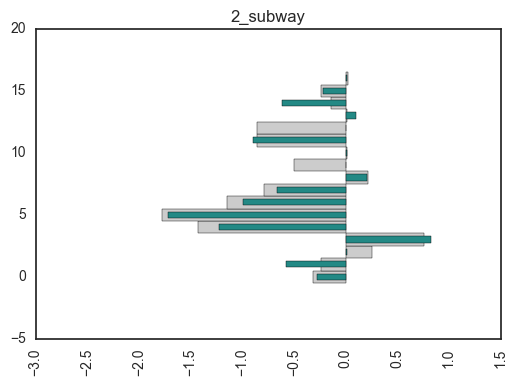

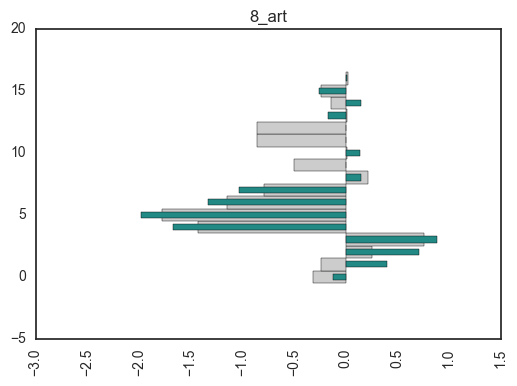

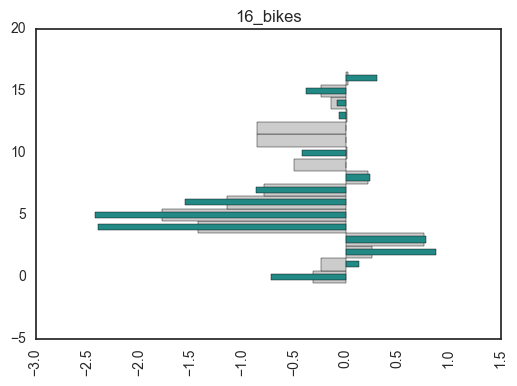

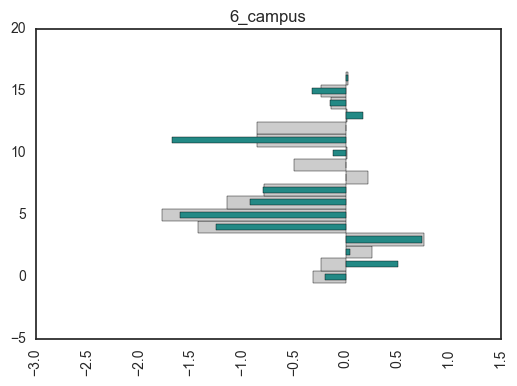

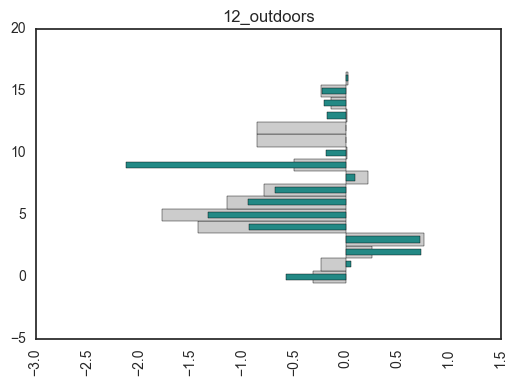

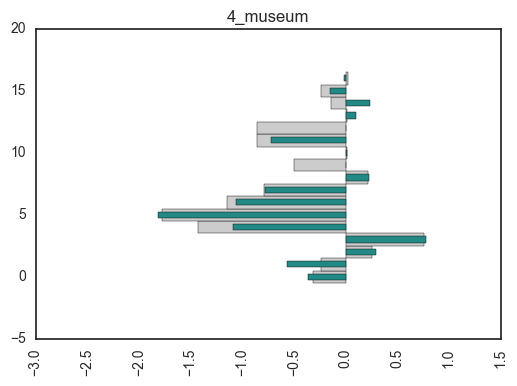

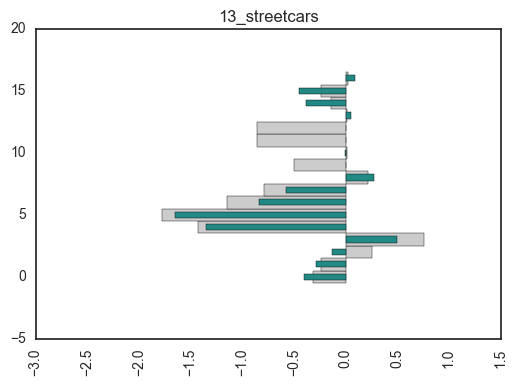

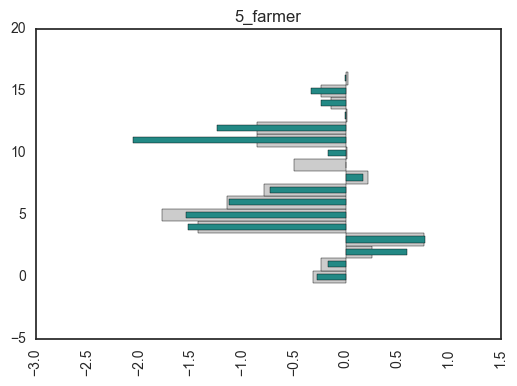

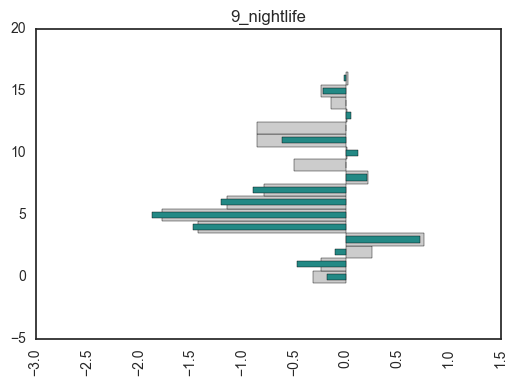

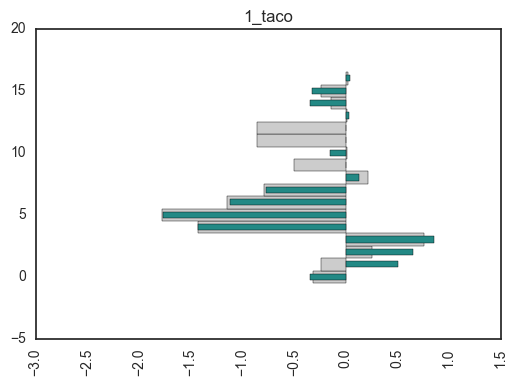

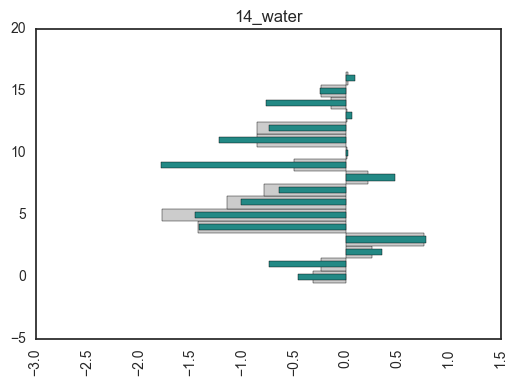

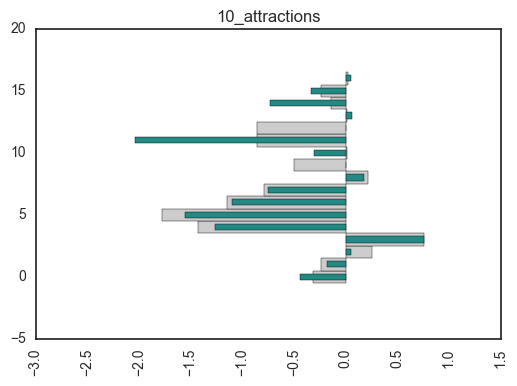

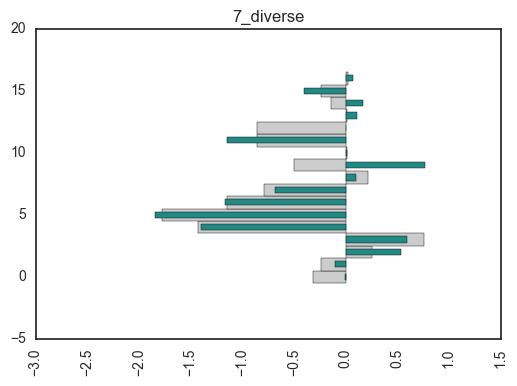

In [138]:
for cluster in cluster_values.keys():
    plot_overlapping_bars(baseline_y, cluster_values[cluster])

In [37]:
def plot_coefficients(dct, key):
    #clusters = range(0,16)
    coefficients = dct[key]    
    fig, ax = plt.subplots()
    fig = sns.barplot(clusters, coefficients)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(key)
    plt.xticks(rotation=90);

In [38]:
coef_values['cancellation_policy_moderate']

[0.17826111773051545,
 0.20458005311906968,
 0.09300983403478491,
 0.2735690136951192,
 0.4774050952586555,
 0.46642923334618724,
 0.23832236802496531,
 0.12865865087872794,
 0.20559226503190092,
 0.2905105124286127,
 0.22676475313690647,
 0.16983342718970906,
 0.0072162978630823105,
 0.09647563723868524,
 0.1524665496728972,
 0.21112753071634371]

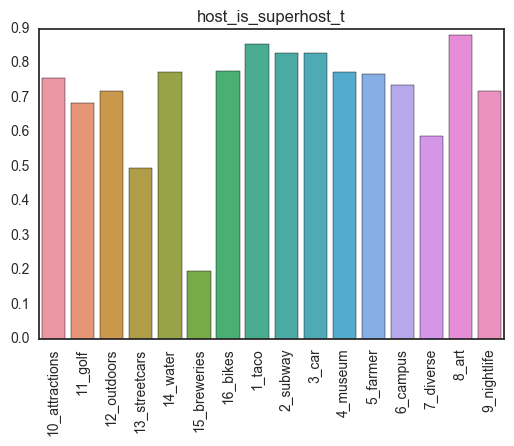

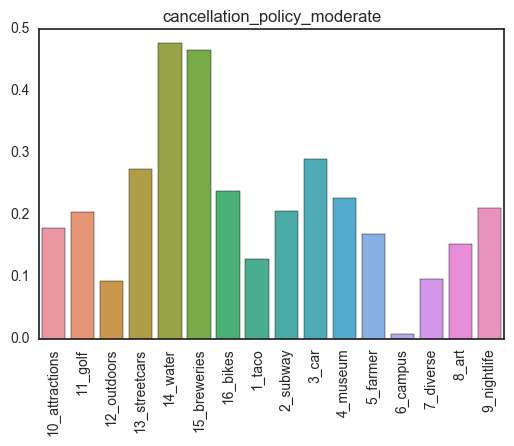

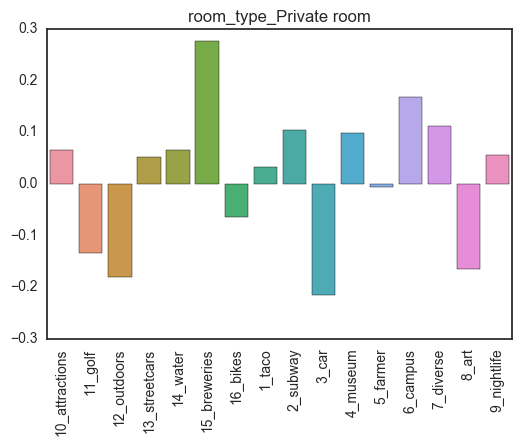

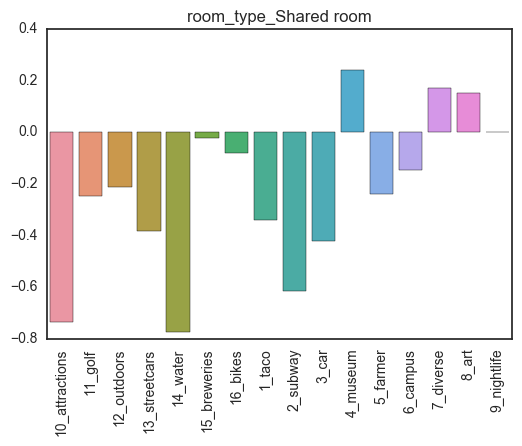

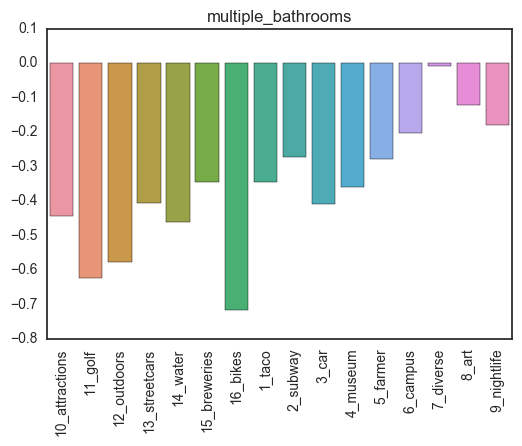

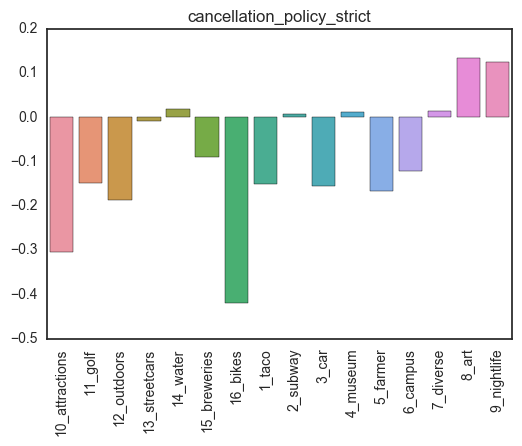

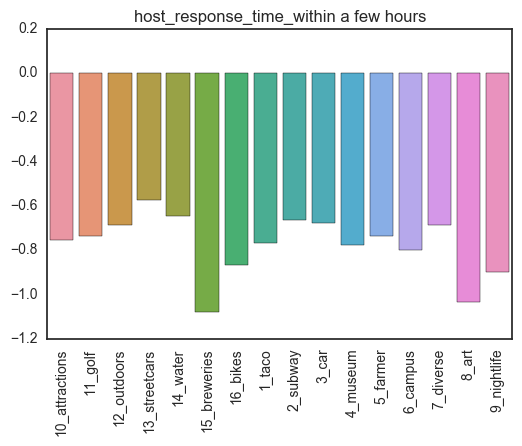

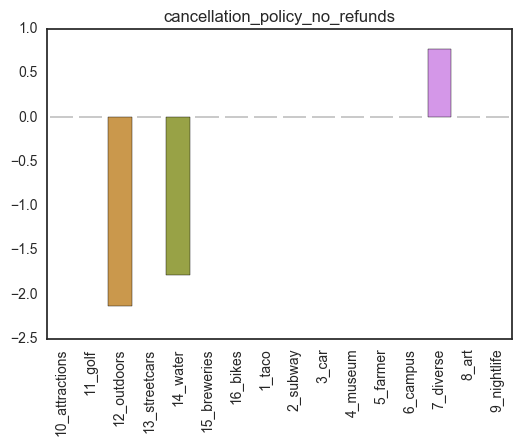

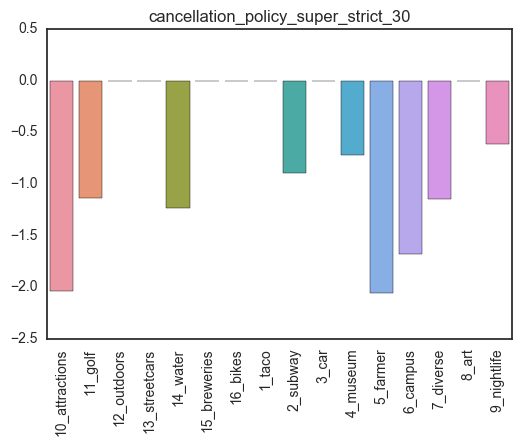

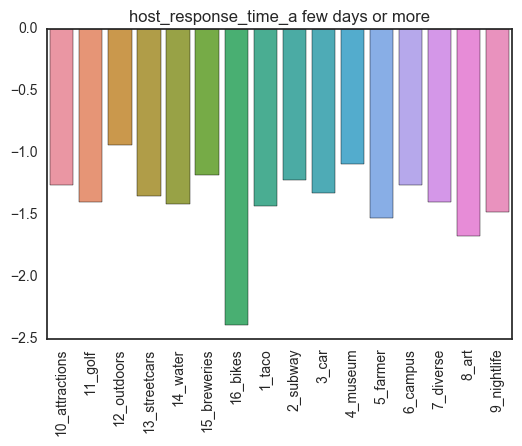

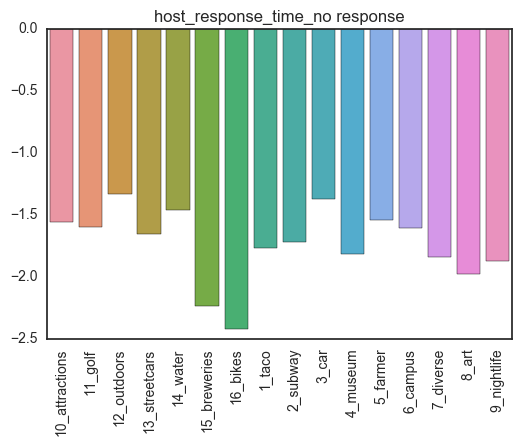

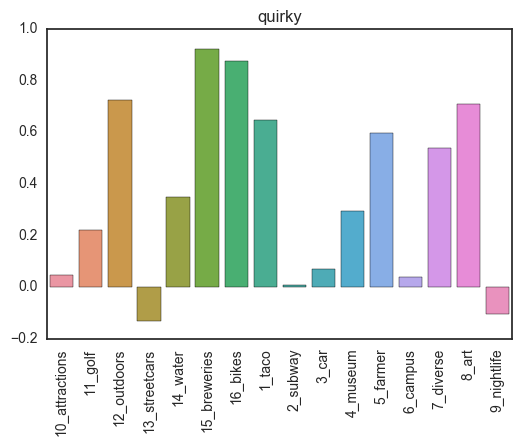

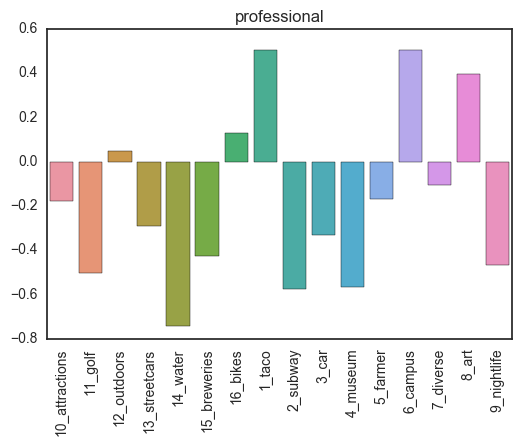

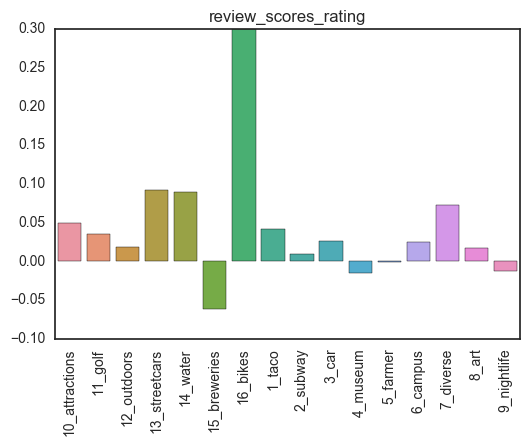

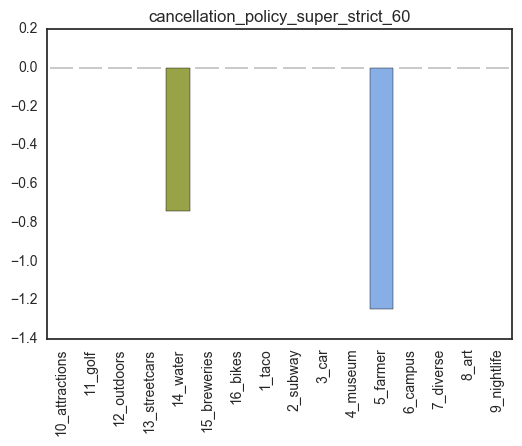

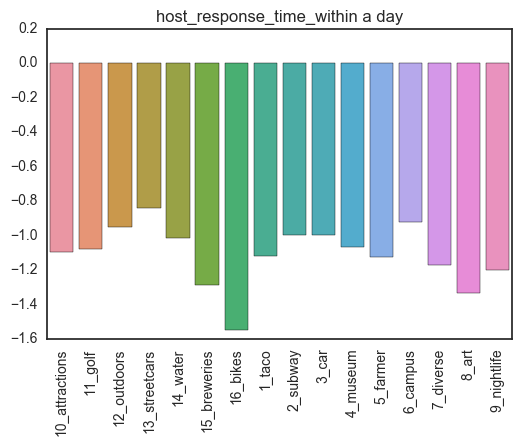

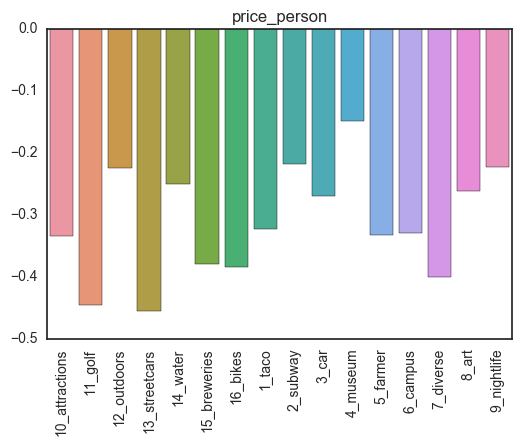

In [39]:
for coefficient in coef_values.keys():
    plot_coefficients(coef_values, coefficient)

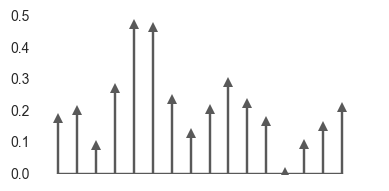

In [52]:
#def plot_for_viz(index, topic, topic_word, features):
    #print features[topic_word[index].argmax()[:3]]
    
f, ax= plt.subplots(1, 1, figsize=(4, 2), sharex=True)
x_min = -1
x_max = 17
#y_min = 0
#y_max = round(max(topic_word[index])*1.1, 1)

ax.set_xlim(x_min, x_max)
#ax.set_ylim(y_min, y_max)
ax.set_frame_on(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

markerline, stemlines, baseline = ax.stem(coef_values['cancellation_policy_moderate'], linefmt='k-', markerfmt='^', basefmt='k-')
plt.setp(markerline, 'color', '#595959')
plt.setp(stemlines, 'color', '#595959')
plt.setp(baseline, 'color', '#595959')

plt.tight_layout()
plt.show()

In [44]:
coef_values

{'cancellation_policy_moderate': [0.17826111773051545,
  0.20458005311906968,
  0.09300983403478491,
  0.2735690136951192,
  0.4774050952586555,
  0.46642923334618724,
  0.23832236802496531,
  0.12865865087872794,
  0.20559226503190092,
  0.2905105124286127,
  0.22676475313690647,
  0.16983342718970906,
  0.0072162978630823105,
  0.09647563723868524,
  0.1524665496728972,
  0.21112753071634371],
 'cancellation_policy_no_refunds': [7.216449660063518e-16,
  4.163336342344337e-17,
  -2.1295436139612383,
  -2.220446049250313e-16,
  -1.7830621771125676,
  7.771561172376096e-16,
  0.0,
  -4.496403249731884e-15,
  0.0,
  -2.7755575615628914e-16,
  2.220446049250313e-16,
  1.4988010832439613e-15,
  3.3306690738754696e-16,
  0.7680891005705291,
  -3.3306690738754696e-16,
  2.914335439641036e-16],
 'cancellation_policy_strict': [-0.3032824536937335,
  -0.14783516420676168,
  -0.1872982606786245,
  -0.008639678573463483,
  0.01995278783130716,
  -0.08898634959329932,
  -0.4196697366633998,
  -0.1